To aid autoassociative recall (sparse recall using partial pattern), we need two components -
1. each pattern remembers a soft mask of the contribution of each 
element in activating it. For example, if an element varies a lot at high activation levels, that element should be masked out when determining activation. On the other hand, if an element has a very specific value every time the element has high activation, then that element is important and should be considered (masked-in).
2. Among the masked-in elements for a pattern, even a small subset (say 20%) almost perfect match should be able to activate the pattern. To find soft-perfect match -

mask weighted dim similarity ${s_i}$ will be high only if input value ${x_i}$ is similar to pattern value ${p_i}$ for that dim AND the pattern cares about that dim (i.e. has ~1 mask ${m_i}$)

${s_i = m_i * \lVert x_i, p_i \rVert}$

${s = {1 \over m} \sum s_i}$ is the total mean similarity across dims that the pattern cares about, where

${m = \sum m_i}$ is the soft version of the number of dims that the pattern cares about.



In [1]:
import math
import torch
import matplotlib.pyplot as plt
import pdb
import pandas as pd  
import seaborn as sns 
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from torchvision import datasets, transforms

%matplotlib inline
# print(plt.style.available)
# plt.style.use('grayscale')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


cpu


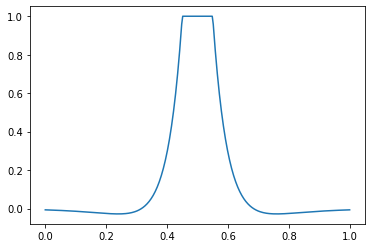

In [2]:
class HP:
  # dataset
  image_height = 10
  image_width = 10
  slice_stride = 3
  image_count_root = 200
  image_count = image_count_root * image_count_root

  # patterns
  pattern_count = 36
  pattern_size = image_height * image_width

  # similarity
  mask_contrast = 3

  # tophat formula derivation https://www.desmos.com/calculator/dnjp9agabt
  tophat_width_factor = 1 # 3.35  # w
  inhibition_factor = 0.4    # f
  inhibition_scale = 0.2     # i

  # training
  lr = 1

def tophat(x, patterns, winning_pattern):
  # winning_patther = W
  # pattern = p

  d1 = (x - patterns).abs()
  d2 = (x - winning_pattern).abs().clamp(min=0.0001)
  d = (d1 - d2).clamp(min=0)
  a = (-d * HP.tophat_width_factor / d2).mean(dim=-1)
  exc = torch.exp(a)
  inh = torch.exp(a * HP.inhibition_factor)

  sim = (exc - HP.inhibition_scale * inh) / (1.0 - HP.inhibition_scale)
  return sim

def show_tophat():
  x = torch.linspace(0.0, 1.0, 300)
  sim = tophat(torch.tensor([0.5]), x.unsqueeze(dim=-1), torch.tensor([0.55]))
  plt.plot(x, sim)
  plt.show()

show_tophat()

In [0]:
def add_gaussian_noise(tensor, mean=0., std=1.):
    t = tensor + torch.randn(tensor.size()).to(device) * std + mean
    t.to(device)
    return t

def show_image_grid(images, vmin=0, vmax=1, w=None, h=None):
  s = images.shape

  assert len(s) == 3
  if w is None or h is None:
    image_grid_size = int(s[0] ** 0.5)
    if image_grid_size > 10:
      return
    w = image_grid_size
    h = image_grid_size
  else:
    assert w * h == s[0]

  if w == 1 and h == 1:
    plt.figure(figsize=(h, w))
    plt.axis("off")
    plt.imshow(images[0].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.viridis, aspect='auto')
  else:
    fig, axs = plt.subplots(nrows=h, ncols=w, figsize=(w, h),
                          subplot_kw={'xticks': [], 'yticks': []})

    
    axs = axs.flat
    for i in np.arange(s[0]):
      axs[i].axis("off")
      axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.viridis, aspect='auto')
      
    fig.subplots_adjust(top=1, left=0, bottom=0, right=1, wspace=0.1, hspace=0.1)

  plt.show()


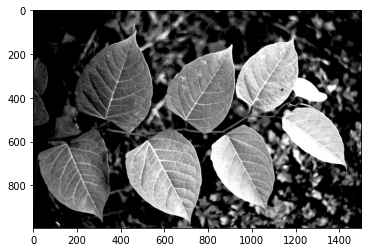

images torch.Size([1, 1, 994, 1500])
images torch.Size([1, 994, 1500])


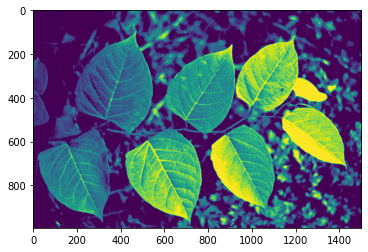

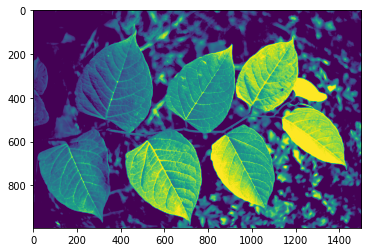

convolutions 163513


In [4]:
def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_cifar10(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def load_imagefolder(batch_size=64):
  loader = torch.utils.data.DataLoader(
      datasets.ImageFolder('/content/drive/My Drive/work/datasets/pattern',
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True)
  
  return loader

def convolve(image_width, image_height, kernel_width, kernel_height, stride):
  convolutions = []
  for x in range(0, image_width - kernel_width + 1, stride):
    for y in range(0, image_height - kernel_height + 1, stride):
      convolutions.append([y, x, y + kernel_height, x + kernel_width])

  return convolutions

def normalize(t):
  # print("mean", t.mean())
  # print("std", t.std())
  t = (t - t.mean()) / max(t.std(), 0.00001)
  # print("max", t.max())
  # print("min", t.min())
  t = t / max(t.max() - t.min(), 0.00001)
  t = t - t.min()
  # print("max", t.max())
  # print("min", t.min())

  return t

def conv_slice(images, kernel_width, kernel_height, stride):
  image_count, image_height, image_width = images.shape
  convolutions = convolve(image_width, image_height, kernel_width, kernel_height, stride)
  print("convolutions", len(convolutions))
  slices = [images[i, c[0]:c[2], c[1]:c[3]] for i in range(image_count) for c in convolutions]

  slices = [normalize(slice) for slice in slices]
  
  slices = torch.stack(slices).float()
  slices = slices.view(slices.shape[0], -1).to(device)
  return slices
  
images = next(iter(load_imagefolder(batch_size=1)))[0]
plt.imshow(images[0].permute(1,2,0))
plt.show()
images = images[:,0,:,:].unsqueeze(1)
ib, ic, ih, iw = images.shape
print("images", images.shape)
images = images.view(ib*ic, ih, iw)
print("images", images.shape)

plt.imshow(images[0], vmin=0, vmax=1)
plt.show()

plt.imshow(normalize(images[0]), vmin=0, vmax=1)
plt.show()
original_dataset = conv_slice(images, kernel_width=HP.image_width, kernel_height=HP.image_height, stride=HP.slice_stride)
offset = 0
original_dataset = original_dataset[offset:offset+HP.image_count]
dataset = original_dataset
show_image_grid(dataset.view(-1, HP.image_height, HP.image_width))

# for i in range(100, 120):
#   print("Patch", i)
#   x = dataset[i]
#   show_image_grid(x.view(HP.image_height, HP.image_width).unsqueeze(0))
#   plt.show()


In [5]:
 dataset.shape

torch.Size([40000, 100])

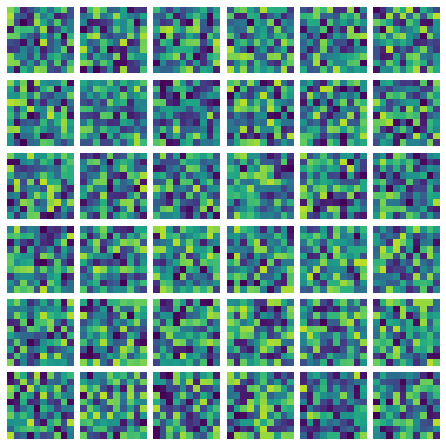

In [6]:
patterns = torch.rand((HP.pattern_count, HP.pattern_size)).to(device) * 0.9
pattern_lr = torch.ones((patterns.shape[0],)).to(device)
pattern_var = torch.ones_like(patterns).to(device) * 10   # start with high var indicating no specificity to any value

original_patterns = patterns.clone().to(device)
show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))

In [0]:
def precision_weighted_distance(x, x_precision, patterns, pattern_var, pattern_lr):
  mask = torch.exp(-pattern_var * HP.mask_contrast) # *3 so that var of 1 gives low enough mask value ~0.5. Thus mask range [0.5,1]
  dist_i = (x - patterns).abs()
  # print("dist_i", dist_i.shape)
  # print("pattern_lr", pattern_lr.shape)
  dist_i = dist_i * torch.exp(-pattern_lr*0.3).unsqueeze(-1) # mature patterns want to be winners for very specific patterns.
  di = (dist_i ** 2) * mask  # distance weighted by importance
  if x_precision is not None:
    di = di * x_precision
  dist = di.sum(dim=-1) / mask.sum(dim=-1) # dividing by mask sum ~= count of # of dims the pattern cares about
  return dist, dist_i

def similarity(x, x_precision, patterns, pattern_var):
  # Formula derivation https://www.desmos.com/calculator/iokn9kyuaq
  # print("x", x)
  # print("patterns", patterns)
  dist, dist_i = precision_weighted_distance(x, x_precision, patterns, pattern_var, pattern_lr)
  # print("dist", dist)
  winner_index = dist.min(dim=0)[1]
  # print("winner_index", winner_index)

  winning_pattern = patterns[winner_index]
  # print("winning_pattern", winning_pattern)

  sim = tophat(x, patterns, winning_pattern)

  # print("sim", sim)

  return sim, winner_index, dist, dist_i

def autoassociative_recall(x, x_precision, patterns, pattern_var, pattern_lr):
  dist, _ = precision_weighted_distance(x, x_precision, patterns, pattern_var, pattern_lr)
  sim = torch.exp(-dist*100) * (1.0 - pattern_lr) # torch.exp(-pattern_lr*1)
  mask = torch.exp(-pattern_var * HP.mask_contrast)
  y = ((sim.unsqueeze(-1) * patterns * mask) / sim.sum(-1)).sum(dim=0)
  # y = ((y - 0.5) * 1.1) + 0.5
  return y

def predict(dataset, dataset_precision, patterns, pattern_var, pattern_lr):
  loss = 0.0
  output = []
  # pdb.set_trace()

  for i in range(dataset.shape[0]):
    x = dataset[i]
    if dataset_precision is not None:
      x_precision = dataset_precision[i]
    else:
      x_precision = None
    y = autoassociative_recall(x, x_precision, patterns, pattern_var, pattern_lr)
    output.append(y)
    loss += torch.dist(x, y)

  output = torch.stack(output)
  # plot_patterns(output, pattern_lr=None, dataset=original_dataset, voronoi=False, annotate=False, figsize=(12,12))
  print("loss", loss)
  return output, loss

# output, loss = predict(original_dataset, patterns, pattern_var, pattern_lr)

In [0]:
def run_dataset(dataset, patterns, pattern_lr, pattern_var):
  # print("pattern_var", pattern_var)
  winner_indices = []
  for x in dataset:
    # plt.imshow(x.view(HP.image_height, HP.image_width), vmin=0, vmax=1, interpolation='none', cmap=plt.cm.plasma, aspect='auto')
    # show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))

    # print("-------")
    sim, winner_index, dist, dist_i = similarity(x=x, x_precision=None, patterns=patterns, pattern_var=pattern_var)
    winner_indices.append(winner_index)
    # winning_pattern = patterns[winner_index]
    # plt.imshow(x.view(HP.image_height, HP.image_width), interpolation='none', cmap=plt.cm.plasma, aspect='auto')
    # plt.show()
    # print("winner index", winner_index)
    # print("winner distance", dist[winner_index])

    # introduce new pattern for x if no pattern is close enough
    # if dist[winner_index] > 0.05:
    #   loser_index = pattern_lr.max(dim=0)[1]
    #   # print("loser_index", loser_index)
    #   patterns[loser_index] = x
    #   pattern_lr[loser_index] = 0.99
    #   sim, winner_index, dist, dist_i = similarity(x=x, x_precision=None, patterns=patterns, pattern_var=pattern_var)

    sim = sim.unsqueeze(-1)
    # print("dist[winner_index]", dist[winner_index] * 100)
    pattern_lr[winner_index] = 0.9 * pattern_lr[winner_index] + 0.1 * (1.0 - torch.exp(-dist[winner_index]))
    pattern_var[winner_index] = 0.9 * pattern_var[winner_index] + 0.1 * dist_i[winner_index]
    # if winner_index == 0:
    #   print("dist_i[winner_index]", dist_i[winner_index])
    #   print("pattern_var[winner_index]", pattern_var[winner_index])

    # print("x", x)
    # print("(x - patterns)", (x - patterns))
    # print("sim", sim)
    delta = (x - patterns) * sim * HP.lr * pattern_lr.unsqueeze(-1)
    # print("delta", delta)
    patterns = patterns + delta
    # show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))
    # winning_pattern = patterns[winner_index]
    # plt.imshow(winning_pattern.view(HP.image_height, HP.image_width), interpolation='none', cmap=plt.cm.plasma, aspect='auto')
    # plt.show()

  print("WINNERS: ", torch.bincount(torch.tensor(winner_indices)))
  patterns.clamp_(0, 1)
  pattern_lr.clamp(0, 1)
  # print("patterns", patterns)
  # print("pattern_lr", pattern_lr)
  return patterns, pattern_lr, pattern_var

def run(patterns=original_patterns*0 + 1.0, epochs=4, noise=0.0):
  pattern_lr = torch.ones((patterns.shape[0],)).to(device) * 1.0
  pattern_var = torch.ones_like(patterns).to(device) * 1.0
  dataset_precision = None

  predict(original_dataset, dataset_precision, patterns, pattern_var, pattern_lr)
  for i in range(epochs):
    dataset = add_gaussian_noise(original_dataset, std=noise)

    # # increase contrast
    # dataset = 2.0 * (dataset - 0.5) + 0.5

    # if (i+1) % int(epochs / 4) == 0:
    #   print("Iteration ", i)
    #   show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))
    #   show_image_grid(torch.exp(-pattern_var.view(-1, HP.image_height, HP.image_width) * HP.mask_contrast))
    patterns, pattern_lr, pattern_var = run_dataset(dataset, patterns, pattern_lr, pattern_var)
    predict(original_dataset, dataset_precision, patterns, pattern_var, pattern_lr)

    if (i+1) % int(epochs / 5) == 0:
      show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))
      show_image_grid(torch.exp(-pattern_var.view(-1, HP.image_height, HP.image_width) * HP.mask_contrast))
      show_image_grid(dataset.view(-1, HP.image_height, HP.image_width))
  return patterns, pattern_lr, pattern_var

loss tensor(nan)
WINNERS:  tensor([    0,     0,     0,    10,     3,     7,    29,     9,     6,   268,
          111,   161,   427,   499,   553,     3,   562,   419,   570,   729,
          558,   363,   706,   743,  1461,  2428,  1667,  1697,  1713,  1643,
         1479,  1841,  1116,  2195, 13896,  2128])
loss tensor(67643.6250)


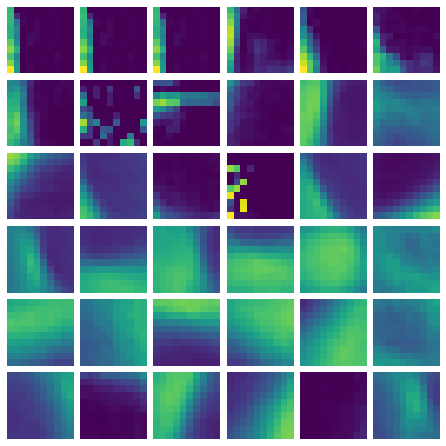

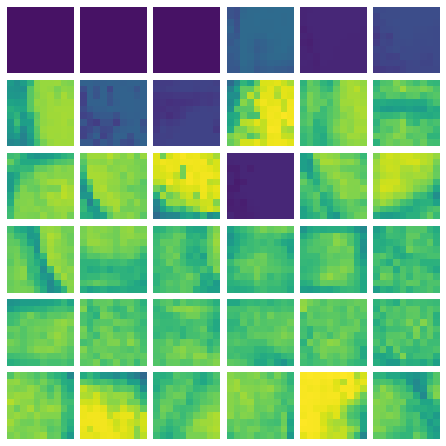

WINNERS:  tensor([  321,   538,   393,   497,   777,   377,   294,   147,   496,  1009,
          578,  1313,   488,   646,  1364,     2,   486,   814,   837,   725,
          882,  1023,   841,  1329,  1027,  1765,   803,  1155,  1043,  1379,
         1211,  1435,   929,   951, 11299,   826])
loss tensor(66318.9922)


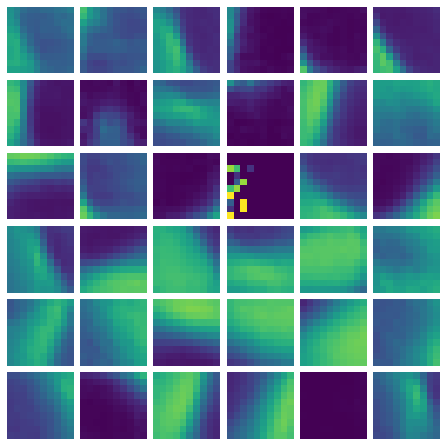

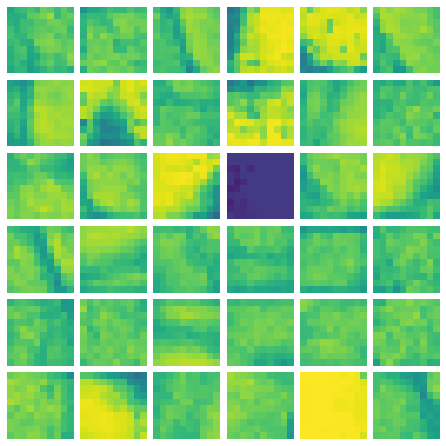

WINNERS:  tensor([  851,   755,   646,   808,  1068,   573,   470,   672,   702,   900,
          574,  1221,   494,   835,  1437,     2,   553,   609,   638,   410,
          896,   934,   655,  1084,   844,  1526,   553,  1114,   934,  1464,
         1160,  1191,   768,   750, 11123,   786])
loss tensor(65668.7109)


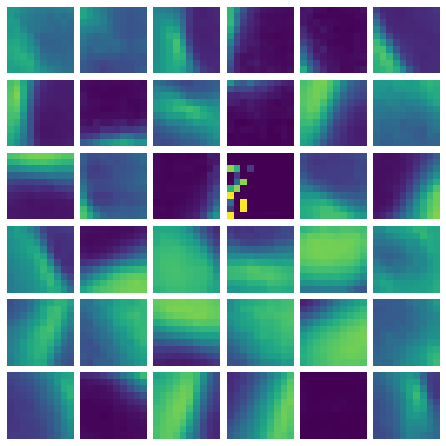

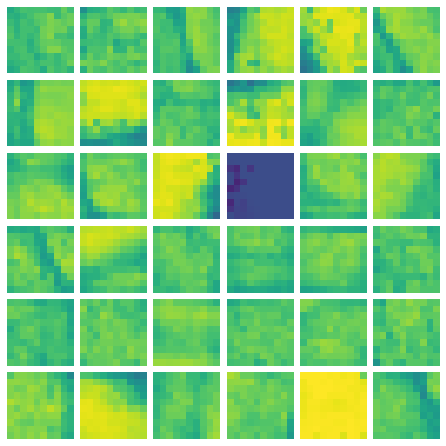

WINNERS:  tensor([  896,   762,   701,   651,  1218,   638,   480,   792,   762,  1002,
          587,  1120,   524,   818,  1403,     2,   681,   623,   587,   468,
          771,   903,   601,  1163,   843,  1365,   542,  1119,   854,  1301,
         1205,  1173,   731,   802, 11171,   741])
loss tensor(65684.7266)


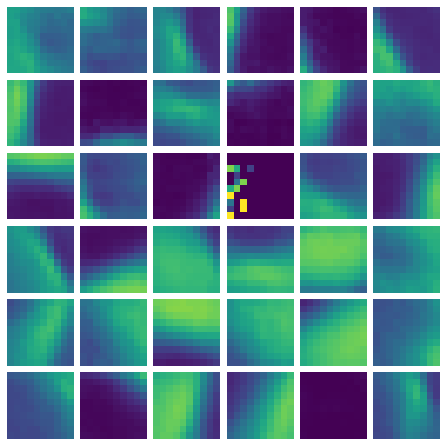

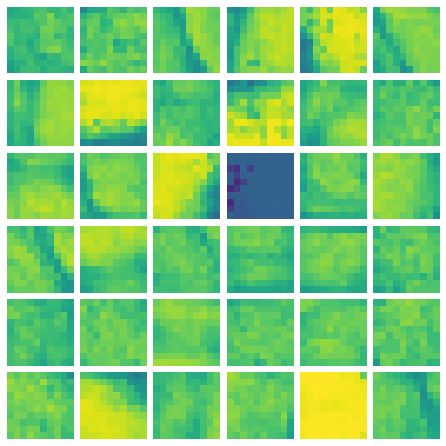

WINNERS:  tensor([  886,   793,   755,   514,  1298,   679,   532,   801,   686,  1138,
          555,  1068,   544,   789,  1395,     2,   772,   628,   716,   496,
          688,   860,   582,  1303,   807,  1292,   528,  1120,   841,  1210,
         1190,  1216,   708,   788, 11166,   654])
loss tensor(65723.5703)


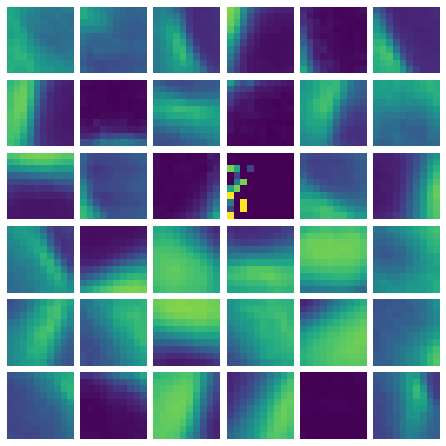

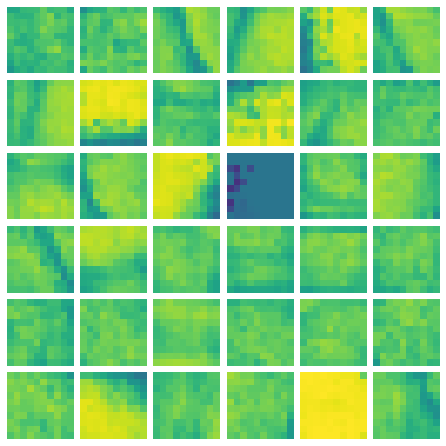

In [9]:
HP.tophat_width_factor = 10000
# HP.lr = 1
patterns, pattern_lr, pattern_var = run(epochs=5)

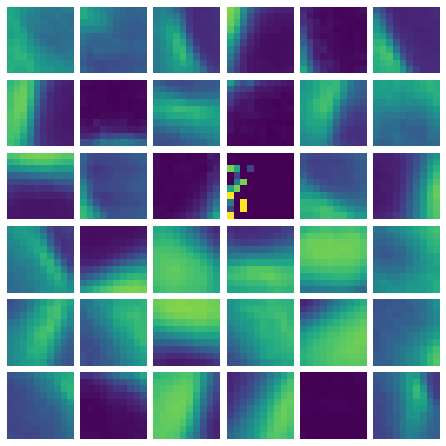

patch, prediction, winning pattern


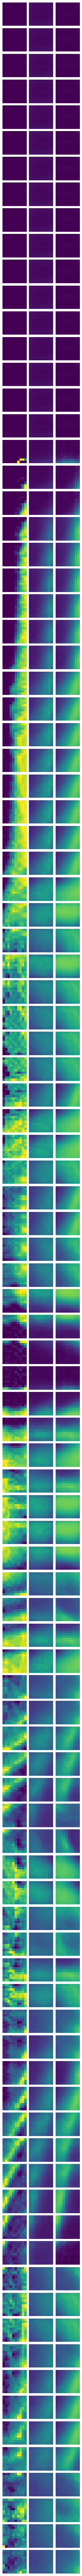

In [10]:
show_image_grid(patterns.view(-1, HP.image_height, HP.image_width))

# for i in range(100, 120):
#   print("Patch", i)
#   x = dataset[i]
#   show_image_grid(x.view(HP.image_height, HP.image_width).unsqueeze(0))
#   plt.show()

result_images = []
for i in range(11000, 11100):
  # print("Patch", i)
  result_images_row = []

  x = dataset[i]
              
  result = autoassociative_recall(x, None, patterns, pattern_var, pattern_lr)

  result_images_row.append(x.view(HP.image_height, HP.image_width))
  # show_image_grid(x.view(HP.image_height, HP.image_width).unsqueeze(0), vmin=None, vmax=None)
  # plt.show()
  result_images_row.append(result.view(HP.image_height, HP.image_width))
  # show_image_grid(result.view(HP.image_height, HP.image_width).unsqueeze(0), vmin=None, vmax=None)
  # plt.show()

  dist, _ = precision_weighted_distance(x, None, patterns, pattern_var, pattern_lr)
  sim = torch.exp(-dist*10) * (1.0 - pattern_lr)
  # print(sim)
  winner_index = dist.min(dim=0)[1]
  # print("winner_index", winner_index)
  winning_pattern = patterns[winner_index]
  result_images_row.append(winning_pattern.view(HP.image_height, HP.image_width))
  # show_image_grid(winning_pattern.view(HP.image_height, HP.image_width).unsqueeze(0), vmin=None, vmax=None)
  # plt.show()

  result_images.append(torch.stack(result_images_row))

print("patch, prediction, winning pattern")
result_images = torch.stack(result_images)
h, w, ih, iw = result_images.shape
show_image_grid(result_images.view(-1, ih, iw), h=h, w=w)


In [11]:
pattern_lr

tensor([0.0234, 0.0192, 0.0182, 0.0123, 0.0179, 0.0163, 0.0147, 0.0124, 0.0206,
        0.0159, 0.0194, 0.0195, 0.0138, 0.0153, 0.0129, 0.3210, 0.0182, 0.0134,
        0.0203, 0.0128, 0.0161, 0.0203, 0.0164, 0.0188, 0.0219, 0.0153, 0.0118,
        0.0166, 0.0147, 0.0168, 0.0147, 0.0109, 0.0172, 0.0144, 0.0006, 0.0228])

In [12]:
torch.exp(-pattern_lr*0.3)

tensor([0.9930, 0.9943, 0.9946, 0.9963, 0.9947, 0.9951, 0.9956, 0.9963, 0.9938,
        0.9952, 0.9942, 0.9942, 0.9959, 0.9954, 0.9961, 0.9082, 0.9946, 0.9960,
        0.9939, 0.9962, 0.9952, 0.9939, 0.9951, 0.9944, 0.9934, 0.9954, 0.9965,
        0.9950, 0.9956, 0.9950, 0.9956, 0.9967, 0.9948, 0.9957, 0.9998, 0.9932])